# Self-supervised Acoustic Word Embeddings

Sequence to sequence model, trained as auto-encoder. Encoder output is used as acoustic word embedding. The following script includes both training and ABX evaluation code. To run the code, you need to modify the "Hyperparameters" block and specify input files:


*   **train_file** : audio segments corresponding to words. Should be processed as sequences of feature vectors (e.g. MFCC vectors)
*   **test_file**: audio segments similar in format to train_file. 
*   **words_file**: list of words corresponding to the test segments. The words should be sequences of characters. 
*   **speakers_file**: list of speaker ids corresponding to the test segments. These are needed for extracting ABX pairs. 

### **Hyperparameter Settings**:
You may want to change the hyperparameters according to feature type. For example, use GRUs instead of LSTMs (except for MFCC features, GRU generally gives better results). The default is 2 layers for both encoder and decoder; this works well for all features except XLSR, for which only 1-layer netwroks could converge, with a larger hid_dim (250 instead of 100). 

*The following is optimized for MFCC features.* 

In [1]:
!pip install Levenshtein


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook  import tqdm
import random
import numpy as np
from random import randint

from torch.nn.utils.rnn import pad_sequence
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from collections import Counter
from google.colab import drive
import math
from Levenshtein import distance
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt


drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Model: 

In [2]:
def length_to_mask(length, max_len=None, dtype=None):
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask


class Encoder(nn.Module):
    def __init__(self, input_dim,  hid_dim=100, n_layers=2, dropout=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.hid_dim = hid_dim
        self.n_layers = n_layers   
        self.device = torch.device("cuda")    
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, bidirectional=True, batch_first = True)
        
    def forward(self, src, src_len):
        packed_src = nn.utils.rnn.pack_padded_sequence(self.dropout(src), src_len.to('cpu'), enforce_sorted=True, batch_first=True )
        outputs, (hidden,cell)= self.rnn(packed_src, None)
        return hidden[self.n_layers*2-2:] 

class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim=100, n_layers=2):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.input_dim = output_dim+hid_dim*2
        self.rnn = nn.LSTM(self.input_dim, self.hid_dim, n_layers, bidirectional=False, batch_first = True)
        self.fc_out = nn.Linear(self.hid_dim, self.output_dim)
        
    def forward(self, input, hidden, hidden_enc):
        rnn_input=torch.cat((input, hidden_enc), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)     
        prediction = self.fc_out(output.squeeze(1))        
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()       
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, src_len, epoch=0):    
        batch_size = src.shape[0]
        decoder_hidden_size = self.decoder.hid_dim
        hidden_enc = self.encoder(src, src_len)
        hidden_enc = torch.cat((hidden_enc[0],hidden_enc[1]), dim=1).unsqueeze(1)
        trg_len=src.shape[1]  
        outputs = torch.zeros(batch_size, trg_len, self.decoder.output_dim).to(self.device)
        start_mfcc = torch.zeros( (src.shape[0], 1, src.shape[2]) , device=self.device) 
        output, hidden = self.decoder(start_mfcc, None, hidden_enc)
        outputs[:,0,:] = output.squeeze(1)
        for t in range(1, trg_len):
            prev_output = output.detach().unsqueeze(1)
            output, hidden = self.decoder(prev_output, hidden, hidden_enc) 
            outputs[:,t,:] = output.squeeze(1)  
        
        mask = length_to_mask(torch.LongTensor(src_len).to(self.device))
        outputs = outputs * mask.unsqueeze(2)
        return outputs



#Hyperparameters:


In [3]:
#Change the following as needed
#MFCC features:
input_dim = 39
train_file='/content/gdrive/My Drive/miniASR_data/miniasr_features/dev-clean-mfcc.pt'
test_file='/content/gdrive/My Drive/miniASR_data/miniasr_features/test-clean-mfcc.pt'
model_save_dir = "/content/gdrive/My Drive/unsupervised_model_mfcc.pt"

#these are probably the same
words_file='/content/gdrive/My Drive/miniASR_data/miniasr_features/test-clean-words.pt'
speakers_file = '/content/gdrive/My Drive/miniASR_data/miniasr_features/test-clean-speakers.pt'


encoder_input_dim = input_dim  
decoder_hidden_dim = 100
encoder_hidden_dim = 100
decoder_output_dim = input_dim
BATCH_SIZE = 512
device = torch.device("cuda")

enc = Encoder(encoder_input_dim, encoder_hidden_dim,  n_layers=2)
dec = Decoder(encoder_input_dim,decoder_hidden_dim,  n_layers=2)
model = Seq2Seq(enc,dec,device).to(device)

#the following optimizer works best for MFCC features. For other features, Adam optimizer is more stable. 
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.3)

#optimizer = optim.Adam(model.parameters())

mse_loss = nn.MSELoss()
best_loss = math.inf

print(model)


def pad_collate(batch):
  lengths = [len(x) for x in batch]
  padded_mfccs = pad_sequence(batch, batch_first=True, padding_value=0)

  return padded_mfccs, lengths

class AudioDataset(Dataset):
  def __init__(self, file_mfcc, sort=True):
        'Initialization'
        self.mfcc_features = torch.load(file_mfcc)
        if sort:
          if self.mfcc_features[0].dim() < 3:
           self.mfcc_features = sorted(self.mfcc_features, key=lambda x: x.size()[0], reverse=True)
          else:
           self.mfcc_features = sorted(self.mfcc_features, key=lambda x: x.size()[1], reverse=True)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.mfcc_features)


  def __getitem__(self, index):
        'Generates one sample of data'
        return self.mfcc_features[index].squeeze(0) 
        

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(39, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(239, 100, num_layers=2, batch_first=True)
    (fc_out): Linear(in_features=100, out_features=39, bias=True)
  )
)


#Load Training & Test Data:

In [4]:


print("Loading data")
train_dataset = AudioDataset(file_mfcc=train_file, sort=True)
print("training dataset size: "+str(len(train_dataset)))
train_loader = DataLoader(train_dataset, shuffle=False,  batch_size=BATCH_SIZE, collate_fn=pad_collate)

test_dataset = AudioDataset(file_mfcc=test_file, sort=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=pad_collate)

words = torch.load(words_file)
for i in range(0, len(words)):
    words[i] = words[i].lower()[:-1]

vocab = np.unique(words)
K=len(vocab)

Loading data
training dataset size: 54402


### Calculate Average & Embeddings before Training

In [5]:

avg_embs=[]
untrained_embs=[]
model.eval()

for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
                src = batch[0]
                src_len = batch[1]
                _sum=torch.sum(src, dim=1)
                i=0
                for _e in _sum:
                    _e=_e/src_len[i]
                    avg_embs.append(_e.numpy())
                    i=i+1
                src=src.to(device)
                src_len, _indices = torch.sort(torch.LongTensor(src_len), dim=0, descending=True, stable=True)
                src=src[_indices]
                h = model.encoder(src, torch.LongTensor(src_len))
                _,_orig=torch.sort(_indices, dim=0, stable=True)
                hidden = torch.cat((h[0],h[1]), dim=1)                
                hidden = hidden.detach().cpu().numpy()
                hidden=hidden[_orig,:]
                for emb in hidden:
                    untrained_embs.append(emb)

print("untrained embeddings size:",len(untrained_embs[0]))
print("average embeddings size:",len(avg_embs[0]))





  0%|          | 0/206 [00:00<?, ?it/s]

untrained embeddings size: 200
average embeddings size: 39


#Training Loop

In [6]:
##training block
EPOCHS = 200 
losses = []
for epo in range(EPOCHS):
  epoch_loss = 0
  model.train()
  for batch in tqdm(train_loader, total=len(train_loader)):
      src = batch[0].to(device)
      src_len = batch[1]
      optimizer.zero_grad()
      output = model(src, torch.LongTensor(src_len), epo)
      output_dim = output.shape[-1]
      output = output[0:].view(-1, output_dim)
      src = src[0:].view(-1, src.shape[-1])     
      loss = mse_loss(output,src)    
      loss.backward()
      optimizer.step()
      scheduler.step()
      epoch_loss += loss.item()

  epoch_loss /= len(train_loader)
  print("Epoch:{}, train loss:{} ".format(epo + 1,epoch_loss))
  if epoch_loss < best_loss:
    best_loss=epoch_loss
    print("saving model in", model_save_dir)
    torch.save(model.state_dict(), model_save_dir)


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:1, train loss:1.10914773528821 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:2, train loss:1.1031003416141616 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:3, train loss:1.102860368857874 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:4, train loss:1.1026501611014392 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:5, train loss:1.1021279870906724 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:6, train loss:1.1013613950426333 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:7, train loss:1.100288925883926 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:8, train loss:1.0987445951622223 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:9, train loss:1.0961851394065072 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:10, train loss:1.089681850415524 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:11, train loss:1.0710866284147602 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:12, train loss:1.055761142868862 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:13, train loss:1.046398258097818 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:14, train loss:1.0311408315863564 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:15, train loss:1.0175598280452123 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:16, train loss:1.0043969148787382 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:17, train loss:0.9886050848203285 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:18, train loss:0.9707544757941059 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:19, train loss:0.9566290980187532 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:20, train loss:0.9401747996561995 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:21, train loss:0.9270605361350229 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:22, train loss:0.9156917734680888 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:23, train loss:0.9001940990162787 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:24, train loss:0.8916199441268066 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:25, train loss:0.8793565664335946 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:26, train loss:0.8670421810907738 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:27, train loss:0.8700762106993488 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:28, train loss:0.851552465251673 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:29, train loss:0.844147410348197 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:30, train loss:0.8321118092982569 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:31, train loss:0.8280487132963733 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:32, train loss:0.8376082259917927 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:33, train loss:0.8237240331195225 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:34, train loss:0.811717641130786 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:35, train loss:0.8062689844692978 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:36, train loss:0.8024511147882337 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:37, train loss:0.8006711195562487 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:38, train loss:0.8034744758472264 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:39, train loss:0.7966107403006509 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:40, train loss:0.7930442133796549 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:41, train loss:0.7895048310823529 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:42, train loss:0.7873756423174778 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:43, train loss:0.7816884250284355 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:44, train loss:0.7771475381940325 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:45, train loss:0.7820118526432002 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:46, train loss:0.7805458301695708 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:47, train loss:0.7699383174147562 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:48, train loss:0.7719153505619442 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:49, train loss:0.7654432086186989 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:50, train loss:0.7575417099712051 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:51, train loss:0.747752020292193 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:52, train loss:0.7509519909029809 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:53, train loss:0.7407698358330771 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:54, train loss:0.7346059635420826 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:55, train loss:0.7307753328965089 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:56, train loss:0.7260018305800785 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:57, train loss:0.7167987233010408 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:58, train loss:0.7052989599303664 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:59, train loss:0.7062505851282137 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:60, train loss:0.6992014493340644 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:61, train loss:0.6909300350697241 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:62, train loss:0.6926703107691257 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:63, train loss:0.6878533380053867 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:64, train loss:0.6765082383824286 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:65, train loss:0.6746929964729559 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:66, train loss:0.6728420928816929 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:67, train loss:0.6638372289800198 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:68, train loss:0.6937004542239359 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:69, train loss:0.6759166750952462 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:70, train loss:0.6610448817226374 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:71, train loss:0.6578964036758815 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:72, train loss:0.6518975975357484 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:73, train loss:0.648984333343595 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:74, train loss:0.6444811898971272 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:75, train loss:0.6422009624053384 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:76, train loss:0.6366947911610114 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:77, train loss:0.6315139534874498 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:78, train loss:0.6309240839191687 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:79, train loss:0.6286258600025534 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:80, train loss:0.6333492091883008 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:81, train loss:0.6372395283150896 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:82, train loss:0.6426025620687787 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:83, train loss:0.6319143162152477 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:84, train loss:0.6345299003280211 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:85, train loss:0.6423599463756954 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:86, train loss:0.6215274517781266 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:87, train loss:0.6275700606475366 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:88, train loss:0.620353807355756 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:89, train loss:0.6136026850370603 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:90, train loss:0.6205296104199418 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:91, train loss:0.6065386798337241 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:92, train loss:0.6108453697133287 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:93, train loss:0.6109516019019011 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:94, train loss:0.6003114720371282 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:95, train loss:0.5953304753682324 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:96, train loss:0.5886046399022932 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:97, train loss:0.5897932205801812 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:98, train loss:0.589278119189717 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:99, train loss:0.5836243016697537 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:100, train loss:0.5778806270840012 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:101, train loss:0.5920118795377072 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:102, train loss:0.576782222941657 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:103, train loss:0.5649119980424364 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:104, train loss:0.5696961417376438 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:105, train loss:0.560366176556204 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:106, train loss:0.5577514653450975 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:107, train loss:0.5502273782948467 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:108, train loss:0.5474060879689511 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:109, train loss:0.5448357716341999 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:110, train loss:0.5356644681680982 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:111, train loss:0.5309029622612712 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:112, train loss:0.5246011027108843 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:113, train loss:0.524455587440562 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:114, train loss:0.5192090448375061 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:115, train loss:0.5200210305574898 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:116, train loss:0.5278045702203412 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:117, train loss:0.5230181632197906 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:118, train loss:0.5367964130138683 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:119, train loss:0.5317307053325332 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:120, train loss:0.5414478219001093 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:121, train loss:0.5336122000328848 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:122, train loss:0.531226963361847 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:123, train loss:0.539172519590253 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:124, train loss:0.5376847464347554 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:125, train loss:0.5535858103605075 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:126, train loss:0.5312909631528587 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:127, train loss:0.5275892214240315 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:128, train loss:0.5274676435461668 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:129, train loss:0.5488533302445278 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:130, train loss:0.5345152340759741 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:131, train loss:0.5274331803633788 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:132, train loss:0.5190789226059601 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:133, train loss:0.5237329398917261 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:134, train loss:0.5165535696199007 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:135, train loss:0.5214787122802199 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:136, train loss:0.5080763143356716 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:137, train loss:0.5149938803966915 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:138, train loss:0.5058826818087391 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:139, train loss:0.4963310528024335 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:140, train loss:0.5009765675134747 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:141, train loss:0.49183119527090374 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:142, train loss:0.49895307184936843 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:143, train loss:0.49119346540107905 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:144, train loss:0.4827162557951758 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:145, train loss:0.4807042675876172 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:146, train loss:0.47398023669407746 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:147, train loss:0.4686167220645976 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:148, train loss:0.466807517075093 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:149, train loss:0.4629777288325479 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:150, train loss:0.46290633514105717 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:151, train loss:0.45571652430797294 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:152, train loss:0.4556023258472157 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:153, train loss:0.4568617245025724 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:154, train loss:0.4552106124775432 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:155, train loss:0.4640935024368429 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:156, train loss:0.47744386357681773 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:157, train loss:0.4706958954300836 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:158, train loss:0.4708602698606865 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:159, train loss:0.4803469420593476 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:160, train loss:0.47660210714719003 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:161, train loss:0.4739874409180935 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:162, train loss:0.5188512839725085 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:163, train loss:0.47924615749131855 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:164, train loss:0.4838724976109567 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:165, train loss:0.48450413276658993 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:166, train loss:0.47871919352317527 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:167, train loss:0.5057184898129133 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:168, train loss:0.4760397295249957 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:169, train loss:0.485275640805191 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:170, train loss:0.47161715150436506 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:171, train loss:0.4775994167985203 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:172, train loss:0.4624158567357286 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:173, train loss:0.46431920545123445 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:174, train loss:0.4619054628588329 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:175, train loss:0.46677485776838856 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:176, train loss:0.4566537630613719 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:177, train loss:0.4522730344645331 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:178, train loss:0.45172512197048864 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:179, train loss:0.4503375830772881 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:180, train loss:0.4456533104459816 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:181, train loss:0.44006992792971783 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:182, train loss:0.44615082707360526 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:183, train loss:0.4444815317325503 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:184, train loss:0.4299589376026225 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:185, train loss:0.4274977208854996 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:186, train loss:0.42307680538881604 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:187, train loss:0.4206821606538006 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:188, train loss:0.4220606709752127 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:189, train loss:0.41480871324784285 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:190, train loss:0.41427301678145045 
saving model in /content/gdrive/My Drive/unsupervised_model_mfcc.pt


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:191, train loss:0.4208061016887148 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:192, train loss:0.42030265955167395 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:193, train loss:0.42865433077388837 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:194, train loss:0.42185256066166354 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:195, train loss:0.4278396659086798 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:196, train loss:0.4297517609094905 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:197, train loss:0.43686246718758737 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:198, train loss:0.43251721477397137 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:199, train loss:0.4277228995739857 


  0%|          | 0/107 [00:00<?, ?it/s]

Epoch:200, train loss:0.43911987835558774 


#Calculate Embeddings of Test set (After Training)

In [7]:
model.load_state_dict(torch.load(model_save_dir))

trained_embs=[]
model.eval()

for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
                src = batch[0].to(device)
                src_len = batch[1]
                src_len, _indices = torch.sort(torch.LongTensor(src_len), dim=0, descending=True, stable=True)
                src=src[_indices]
                h = model.encoder(src, torch.LongTensor(src_len))
                _,_orig=torch.sort(_indices, dim=0, stable=True)
                hidden = torch.cat((h[0],h[1]), dim=1)             
                hidden = hidden.detach().cpu().numpy()
                hidden=hidden[_orig,:]
                for emb in hidden:
                    trained_embs.append(emb)

print("No.of embeddings obtained -",len(trained_embs))



  0%|          | 0/206 [00:00<?, ?it/s]

No.of embeddings obtained - 52576


#Kmeans Clustering of Test Embeddings. 

In [8]:
print('k-means clustering with k =', K)
kmeans = KMeans(n_clusters=K, init='random').fit(trained_embs)  
 
h_score = homogeneity_score(words, kmeans.labels_)
c_score = completeness_score(words, kmeans.labels_)
v_score = v_measure_score(words, kmeans.labels_)

print('homogenity: ', h_score)
print('completeness: ', c_score)
print('v score: ', v_score)


def avg_editDist(word_list):
    transformed_strings = np.array(word_list).reshape(-1,1)
    A=pdist(transformed_strings,lambda x,y: distance(x[0],y[0])/max(len(x[0]), len(y[0])))
    A=squareform(A)
    #sum the off diagonal elements, and divide by 2 (symmetric)
    sum = (A.sum() - np.diag(A).sum())/2 
    n=A.shape[0]
    total = n*(n-1)/2
    return sum/total

_words_=np.array(words)

sum=0
total=0
list_dist=[]
for cid in range(K):
  idx=np.where(kmeans.labels_ == cid)[0]
  _words=_words_[idx]
  if(len(_words) > 1):
   _dist=avg_editDist(_words)
   _len=len(_words)
   list_dist.append(_dist)
  elif len(_words) == 1:
   _dist=0
   _len=1
   list_dist.append(-0.1)
  else:
   _dist=0
   _len=0
   list_dist.append(-0.1)

  sum+=_dist*_len
  total+=_len

print("\naverage edit distance within each cluster:" , sum/total)

#calculate labeling based on clusters:
_labels_=[]
for cid in range(K):
  idx=np.where(kmeans.labels_ == cid)[0]
  _words=_words_[idx]
  if(len(_words) > 1):
    _c=Counter(_words)
    _w=_c.most_common(1)[0][0]
    _labels_.append(_w)
  elif len(_words) == 1:
    _labels_.append(_words[0])
  else:
    _labels_.append("")


correct=0
edit_dist_total=0
incorrect=0
for i in range(len(words)):
  if _labels_[kmeans.labels_[i]] == words[i]:
    correct+=1
  else:
    edit_dist_total+=distance(_labels_[kmeans.labels_[i]], words[i])/max(len(_labels_[kmeans.labels_[i]]), len(words[i]))
    incorrect+=1
print('\naccuracy of cluster labeling: ', correct/len(words))
print('avg edit distance for incorrect labels ', edit_dist_total/incorrect)


_words_=np.array(words)

print('\n\nFirst 10 clusters')
for cid in range(10):
  idx=np.where(kmeans.labels_ == cid)[0]
  print(_words_[idx])

k-means clustering with k = 8138
homogenity:  0.715881138117765
completeness:  0.6253034097817292
v score:  0.6675336624844697

average edit distance within each cluster: 0.5047683724330919

accuracy of cluster labeling:  0.47234479610468655
avg edit distance for incorrect labels  0.7516054334790497


First 10 clusters
['about']
['was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was'
 "what's" 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was'
 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'always' 'was' 'was'
 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'was'
 'was' 'was' 'was' 'was' 'was' 'was' 'was' 'his' 'was' 'was' 'was' 'was'
 'was' 'was' 'with' 'was']
['embrace' 'becomes' 'rejoice' 'rejoice' 'rejoice']
['did']
['man' 'men']
['others' 'others' 'others']
['danes']
['the']
['accents' 'excess']
['eat' 'he']


##Plot Histogram of Edit Distance Distribution

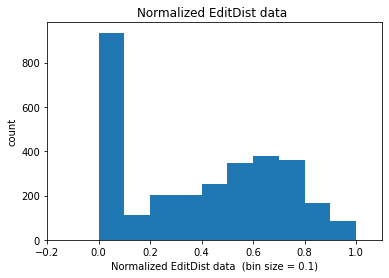

In [9]:


# fixed bin size
bins = np.arange(0, 1.1, 0.1) # fixed bin size
data=np.array(list_dist)
plt.xlim([min(data)-0.1, max(data)+0.1])

plt.hist(data, bins=bins, alpha=1)
plt.title('Normalized EditDist data ')
plt.xlabel('Normalized EditDist data  (bin size = 0.1)')
plt.ylabel('count')

plt.show()

#Calculate Average Cosine Similarity 
Within & Across speakers

#Extract word pairs for evaluation

* Different occurrences of the same spoken by the same speaker
* Same word spoken by different speakers
* Different words spoken by the same speaker


In [10]:
speakers=torch.load(speakers_file)
_speakers_=np.array(speakers)
speaker_ids = np.unique(speakers)
_words_=np.array(words)

min_len = 1

#exract words spoken by the same speaker multiple times
print('All words extracted must have at least', min_len, 'character(s)' )
print('extracting occurrences of the same word spoken by the same speaker ...')
same_speaker_same_words=[]
w_list_1={}
for sid in speaker_ids:
  idx=np.where(_speakers_ == sid)[0]
  s_words = _words_[idx]
  s_vocab=np.unique(s_words)
  for word in s_vocab :
    if len(word)>=min_len:
     sub_idx=np.where(s_words == word)[0]
     if len(sub_idx) >= 2 :
       #sub_idx=np.random.choice(sub_idx, size=2, replace=False)
       same_speaker_same_words.append(idx[sub_idx])
       w_list_1[word]=1

#check
print('number of words:', len(same_speaker_same_words))
i=randint(0,len(same_speaker_same_words))
print('example:')
print(_words_[same_speaker_same_words[i]])
print(_speakers_[same_speaker_same_words[i]])


#exract occurrences of same word spoken by different speakers
print('\nextracting occurrences of the same word spoken by different speakers ...')
diff_speaker_same_words=[]
w_list_2={}
for word in vocab:
  if len(word)>=min_len:
   idx=np.where(_words_ == word)[0]
   w_speakers = _speakers_[idx]
   s_ids=np.unique(w_speakers)
   if len(s_ids) >= 2 :
      temp={}
      for _i in idx:
        temp[speakers[_i]]=_i
      sub_idx=list(temp.values())
      #sub_idx=np.random.choice(sub_idx, size=2, replace=False)
      diff_speaker_same_words.append(sub_idx)
      w_list_2[word]=1

#check
print('number of words:', len(diff_speaker_same_words))
i=randint(0,len(diff_speaker_same_words))
print('example:')
print(_words_[diff_speaker_same_words[i]])
print(_speakers_[diff_speaker_same_words[i]])


print('\nextracting lists of different words spoken by the same speaker ...')
same_speaker_diff_words=[]
for sid in speaker_ids:
  idx=np.where(_speakers_ == sid)[0]
  s_words = _words_[idx]
  s_vocab=np.unique(s_words)
  final_idx={}
  for _i in idx:
    if len(words[_i]) >=min_len:
      final_idx[words[_i]] = _i
  same_speaker_diff_words.append(list(final_idx.values()))


All words extracted must have at least 1 character(s)
extracting occurrences of the same word spoken by the same speaker ...
number of words: 6557
example:
['aboard' 'aboard']
['8463' '8463']

extracting occurrences of the same word spoken by different speakers ...
number of words: 3150
example:
['campaign' 'campaign']
['6829' '8463']

extracting lists of different words spoken by the same speaker ...


In [11]:

def avg_cosine(A):
    A=cosine_similarity(A)
    #sum the off diagonal elements, and divide by 2 (symmetric)
    sum = (A.sum() - np.diag(A).sum())/2 
    n=A.shape[0]
    total = n*(n-1)/2
    return sum/total

_embeddings_=np.array(trained_embs)

sum=0
total=0
for i in range(len(same_speaker_diff_words)):
   sum+=avg_cosine(_embeddings_[same_speaker_diff_words[i]])
   total+=1
print('Average cosine similarity between different words spoken by the same speaker',sum/total)
print('total', total)
sum=0
total=0
for i in range(len(same_speaker_same_words)):
   w=words[same_speaker_same_words[i][0]]
   score=avg_cosine(_embeddings_[same_speaker_same_words[i]])
   sum+=score
   total+=1
print('Average cosine sim between the same word spoken by the same speaker', sum/total)
print('total', total)

sum=0
total=0
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   sum+=avg_cosine(_embeddings_[diff_speaker_same_words[i]])
   total+=1
print('Average cosine sim between the same word spoken by different speakers', sum/total)

print('total', total)

Average cosine similarity between different words spoken by the same speaker 0.3198774068963647
total 40
Average cosine sim between the same word spoken by the same speaker 0.5854903458913304
total 6557
Average cosine sim between the same word spoken by different speakers 0.5815227298521493
total 3150


#Extract Words for ABX Evaluation

In [12]:
def contain_same_chars(w1, w2):
  return distance(sorted(w1),sorted(w2))<1
np.random.seed(2244)
within_ABX=[]
for i in range(len(same_speaker_same_words)):
   w=words[same_speaker_same_words[i][0]]
   sid1=speakers[same_speaker_same_words[i][0]]
   if len(w) >= 5:
     #pick two words, these will be A and X
     AX=np.random.choice(same_speaker_same_words[i], size=2, replace=False)
     #find a word by the same speaker, len 5, but has editDist =1 
     for j in range(len(same_speaker_diff_words)):
       sid2=speakers[same_speaker_diff_words[j][0]]
       if sid2 == sid1:
         for k in range(len(same_speaker_diff_words[j])):
           w2=words[same_speaker_diff_words[j][k]]
           if len(w)== len(w2):
             if distance(w, w2)>0 and distance(w, w2)<=2:
               B=same_speaker_diff_words[j][k]
               within_ABX.append([AX[0], B, AX[1]])
             elif distance(w, w2)>2 and contain_same_chars(w, w2):
               B=same_speaker_diff_words[j][k]

print(len(within_ABX))
print("Examples of within-speaker pairs")
for i in random.sample(range(0, len(within_ABX)), 3):
   print(_words_[within_ABX[i]])
   print(_speakers_[within_ABX[i]])


across_ABX=[]
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   if len(w) >= 5:
     ss=0
     while ss < len(diff_speaker_same_words[i])-1:
      #pick two words, these will be A and X
      A=diff_speaker_same_words[i][ss]
      X=diff_speaker_same_words[i][ss+1]
      sid1=speakers[A]
      #find a word by the same speaker, A, len 5, but has editDist =1
      for j in range(len(same_speaker_diff_words)):
         sid2=speakers[same_speaker_diff_words[j][0]]
         if sid2 == sid1:
           for k in range(len(same_speaker_diff_words[j])):
             w2=words[same_speaker_diff_words[j][k]]
             if len(w)== len(w2):
               if distance(w, w2)>0 and distance(w, w2)<=2:
                 B=same_speaker_diff_words[j][k]
                 across_ABX.append([A, B, X])
               elif distance(w, w2)>2 and contain_same_chars(w, w2):
                 B=same_speaker_diff_words[j][k]
      ss+=2
          
print(len(across_ABX))
print("Examples of across-speaker pairs")
for i in random.sample(range(0, len(across_ABX)), 3):
   print(_words_[across_ABX[i]])
   print(_speakers_[across_ABX[i]])


     
speaker_ABX=[]
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   if len(w) >= 5:
     ss=0
     while ss < len(diff_speaker_same_words[i])-1:
      #pick two words, these will be A and X
      A=diff_speaker_same_words[i][ss]
      B=diff_speaker_same_words[i][ss+1]
      sid1=speakers[A]
      #find a word by the same speaker, A, len 5, but has editDist =1
      for j in range(len(same_speaker_diff_words)):
         sid2=speakers[same_speaker_diff_words[j][0]]
         if sid2 == sid1:
           for k in range(len(same_speaker_diff_words[j])):
             w2=words[same_speaker_diff_words[j][k]]
             if len(w)== len(w2):
               if distance(w, w2)>0 and distance(w, w2)<=2:
                 X=same_speaker_diff_words[j][k]
                 speaker_ABX.append([A, B, X])
      ss+=2
                  
print(len(speaker_ABX))
print("Examples of speaker ABX pairs:")
for i in random.sample(range(0, len(speaker_ABX)), 3):
   print(_words_[speaker_ABX[i]])
   print(_speakers_[speaker_ABX[i]])



2244
Examples of within-speaker pairs
['ideas' 'ideal' 'ideas']
['2961' '2961' '2961']
['great' 'bread' 'great']
['5142' '5142' '5142']
['matter' 'mother' 'matter']
['4970' '4970' '4970']
3149
Examples of across-speaker pairs
['round' 'would' 'round']
['2094' '2094' '260']
['smile' 'still' 'smile']
['8455' '8455' '908']
['young' 'going' 'young']
['7127' '7127' '8455']
3149
Examples of speaker ABX pairs:
['first' 'first' 'burst']
['8463' '8555' '8463']
['doing' 'doing' 'point']
['7176' '8230' '7176']
['ought' 'ought' 'night']
['5142' '6829' '5142']


#ABX Evaluation

In [13]:
from scipy import spatial
correct=0
_embeddings_=np.array(trained_embs)

for i in range(len(within_ABX)):
  embs=_embeddings_[within_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('ABX error rate within speakers: ', 1-(correct/len(within_ABX)))

correct=0
for i in range(len(across_ABX)):
  embs=_embeddings_[across_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('ABX error rate across speakers: ', 1-(correct/len(across_ABX)))


correct=0
for i in range(len(speaker_ABX)):
  embs=_embeddings_[speaker_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('speaker ABX error rate: ', 1-(correct/len(across_ABX)))



ABX error rate within speakers:  0.11319073083778963
ABX error rate across speakers:  0.1797395998729755
speaker ABX error rate:  0.3674182280088917


#DTW-based ABX evaluation

Using original feature vectors as a basis for comparison, and DTW as the distance metric

In [14]:
!pip install dtw

from dtw import dtw,accelerated_dtw
_feats_=np.array(torch.load(test_file))
correct=0
for i in range(len(within_ABX)):
  embs=_feats_[within_ABX[i]]
  c1, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[0][0], 'cosine')
  c2, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[1][0], 'cosine')
  if c1<c2:
    correct+=1
print('ABX error rate within: ', 1-(correct/len(within_ABX)))

correct=0
for i in range(len(across_ABX)):
  embs=_feats_[across_ABX[i]]
  c1, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[0][0], 'cosine')
  c2, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[1][0], 'cosine')
  if c1<c2:
    correct+=1
print('ABX error rate across: ', 1-(correct/len(across_ABX)))

correct=0
for i in range(len(speaker_ABX)):
  embs=_feats_[speaker_ABX[i]]
  c1, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[0][0], 'cosine')
  c2, cost, acc_cost, path = accelerated_dtw(embs[2][0], embs[1][0], 'cosine')
  if c1<c2:
    correct+=1
print('error rate for speakers: ', 1-(correct/len(speaker_ABX)))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5317 sha256=4fb4a272efad695ec97206f751cf8d5bf6362fbb749462080556d6b437a8626e
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


ABX error rate within:  0.09982174688057044
ABX error rate across:  0.19847570657351543
error rate for speakers:  0.3362972372181645
